Data is from [this dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) to predict churn from a telecom company.

# A Basic Model As A Starting Point

Model building isn't our focus, so I won't go into great depth on this. But it gives a model to use

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.compose import make_column_selector as selector
from wandb.xgboost import WandbCallback
from xgboost import XGBClassifier

plt.style.use('fivethirtyeight')

data = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
run1 = wandb.init(project="profit_curves")

target = "Churn"
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(target, axis=1), data[target] == "Yes", test_size=0.2, random_state=0
)
cols_to_use = [
    "tenure",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "MonthlyCharges",
]

preprocessor = ColumnTransformer(
    transformers=[("one_hot", OneHotEncoder(), selector(dtype_include="object"))],
    remainder="passthrough",  # Leave numerical variables unchanged
)

# Create pipeline
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier())])
pipeline.fit(X_train[cols_to_use], y_train)
y_pred = pipeline.predict_proba(X_test[cols_to_use])[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
log_loss_val = log_loss(y_test, y_pred)

# Log metrics to W&B
wandb.log({"roc_auc": roc_auc, "log_loss": log_loss_val})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: danbecker. Use `wandb login --relogin` to force relogin


In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix

threshold = 0.5  # Set your custom threshold here
y_pred_binary = np.where(y_pred >= threshold, 1, 0)
cm = confusion_matrix(y_test, y_pred_binary)

# format is
# [[TN, FP],
#  [FN, TP]]

# Log confusion matrix to W&B
wandb.log({'confusion_matrix': wandb.plot.confusion_matrix(
    probs=None,
    y_true=y_test.tolist(),
    preds=y_pred_binary.tolist(),
    class_names=['Not Churn', 'Churn'])}
    )


print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[912 129]
 [179 189]]


In [4]:
def profit_curve(y_true, y_pred, payoff_matrix, n_points=101):
    """Calculate profit curve for a binary classifier.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted probabilities.
        payoff_matrix (array-like): Payoff matrix.
        n_points (int): Number of points to calculate.

    Returns:
        tuple: x and y values for the profit curve.
    """
    # Calculate profit for each threshold
    thresholds = np.linspace(0, 1, n_points)
    profits = []
    for threshold in thresholds:
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        cm = confusion_matrix(y_true, y_pred_binary)
        profit = (cm * payoff_matrix).sum()
        profits.append(profit)
    return thresholds, profits


# Costs $80 to give discount to a customer who will not churn
# Worth $200 to give discount to a customer who will otherwise churn
payoff_matrix = np.array([[0, -80], [0, 200]])
first_thresholds, first_profits = profit_curve(y_test, y_pred, payoff_matrix)
print(first_thresholds)
print(first_profits)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
[-9680, 13160, 15560, 19440, 21400, 23120, 25000, 26120, 26960, 27840, 28680, 29840, 29360, 29560, 30200, 30280, 30440, 30680, 31360, 32080, 32040, 32080, 32360, 31760, 31800, 31960, 32000, 31440, 31480, 31600, 31800, 30400, 30320, 30560, 31040, 30680, 30680, 30040, 29960, 30120, 30360, 29440, 28440, 28080, 28400, 28200, 28120, 28400, 28160, 27920, 27480, 27640, 27080, 26520, 26360, 26040, 26160, 26440, 25680, 25600, 25560, 24600, 24640, 24880, 24880, 24560, 23560, 23280, 22920, 22

In [5]:
# Log your data as a wandb.Table
def log_profit_curve(thresholds, profits):
    data = [[x, y] for (x, y) in zip(thresholds, profits)]
    profit_curve_table = wandb.Table(data=data, columns=["Threshold", "Profit"])
    line_plot = wandb.plot.line(profit_curve_table, x='Threshold', y='Profit', title='Value of Offering Discounts to Prevent Churn')
    wandb.log({"profit_curve_table": profit_curve_table, "profit_curve": line_plot})

log_profit_curve(first_thresholds, first_profits)

In [6]:
def find_best_threshold_and_profit(thresholds, profits):
    """Find the best threshold and profit.
    
    Args:
        thresholds (array-like): Threshold values.
        profits (array-like): Profit values.
    
    Returns:
        tuple: Best threshold and profit.
    """
    best_profit = max(profits)
    best_threshold = thresholds[profits.index(best_profit)]
    return best_threshold, best_profit
    
best_thresh, best_profits = find_best_threshold_and_profit(first_thresholds, first_profits)

wandb.log({"best_threshold": best_thresh, "best_profit": best_profits})

print(f"Ideal threshold is {best_thresh:.2f} which yields profits of ${best_profits:.0f}")


Ideal threshold is 0.22 which yields profits of $32360


In [7]:
# We'll finish our first experiment (run) here. 
wandb.finish()

best_profit,▁
best_threshold,▁
log_loss,▁
roc_auc,▁
best_profit,32360
best_threshold,0.22
log_loss,0.47183
roc_auc,0.81526


# Prioritizing Work

In [8]:
# start a new W&B run
run2 = wandb.init(project="profit_curves")

field_lost_in_broken_pipeline = "Contract"

# refit model and get new predictions without this field
new_cols_to_use = [col for col in cols_to_use if col != field_lost_in_broken_pipeline]
pipeline.fit(X_train[new_cols_to_use], y_train,
             classifier__callbacks=[WandbCallback()]
             )
new_y_pred = pipeline.predict_proba(X_test[new_cols_to_use])[:, 1]

roc_auc = roc_auc_score(y_test, new_y_pred)
log_loss_val = log_loss(y_test, new_y_pred)

# Log metrics to W&B
wandb.log({"roc_auc": roc_auc, "log_loss": log_loss_val})

new_thresholds, new_profits = profit_curve(y_test, new_y_pred, payoff_matrix)
log_profit_curve(new_thresholds, new_profits)
new_best_thresh, new_best_profits = find_best_threshold_and_profit(new_thresholds, new_profits)
wandb.log({"best_threshold": new_best_thresh, "best_profit": new_best_profits})
print(f"Ideal threshold is {new_best_thresh:.2f} which yields profits of ${new_best_profits:.0f}")

/Users/dan/opt/anaconda3/envs/wandb/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


Ideal threshold is 0.24 which yields profits of $30800


In [9]:
# Let's finish our second run here
wandb.finish()

best_profit,▁
best_threshold,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
log_loss,▁
roc_auc,▁
best_profit,30800
best_threshold,0.24
epoch,99
log_loss,0.47603
roc_auc,0.80646


In [10]:
print(f"Change in profit due to lost field: {new_best_profits - best_profits:.0f}")

Change in profit due to lost field: -1560


The most important field is `tenure`. It is an interesting exercise to see modify this code slightly and see how the results change when you remove `tenure`.

## Model Improvements

In [11]:
# Let's start our third run here. Because it's a synthtic dataset, we'll use tags to indicate that
run3 = wandb.init(project="profit_curves", tags=["synthetic_data"])

In [12]:
def make_synth_accurate_data(y_pred, y_true, closeness_factor=0.1):
    """Create synthetic data that is accurate.

    Args:
        y_pred (array-like): Predicted probabilities.
        y_true (array-like): True labels.
        closeness_factor (float): A measure of how much to increase the accuracy of the synthetic data.

    Returns:
        array: Synthetic data.
    """
    errors = y_pred - y_true
    synth_data = y_pred - errors * closeness_factor
    synth_data_AUC = roc_auc_score(y_true, synth_data)
    print(
        f"closeness_factor: {closeness_factor:.2f}.   AUC of synthetic data: {synth_data_AUC:.2f}"
    )
    return synth_data


for i in np.linspace(0, 0.2, 11):
    make_synth_accurate_data(y_pred, y_test, i)

closeness_factor: 0.00.   AUC of synthetic data: 0.82
closeness_factor: 0.02.   AUC of synthetic data: 0.83
closeness_factor: 0.04.   AUC of synthetic data: 0.85
closeness_factor: 0.06.   AUC of synthetic data: 0.86
closeness_factor: 0.08.   AUC of synthetic data: 0.87
closeness_factor: 0.10.   AUC of synthetic data: 0.88
closeness_factor: 0.12.   AUC of synthetic data: 0.89
closeness_factor: 0.14.   AUC of synthetic data: 0.90
closeness_factor: 0.16.   AUC of synthetic data: 0.91
closeness_factor: 0.18.   AUC of synthetic data: 0.92
closeness_factor: 0.20.   AUC of synthetic data: 0.93


A closeness factor of 0.14 creates synthetic data that's a proxy for how good we expect predictions to be after this modeling improvement (recall that we hypothesized the modeling improvement would yield an AUC of 0.9)

In [13]:
synth_preds = make_synth_accurate_data(y_pred, y_test, 0.14)
print(
    f"""
Sanity check that means make sense:
{synth_preds.mean():.3f}
{y_pred.mean():.3f}
{y_test.mean():.3f}
"""
)

closeness_factor: 0.14.   AUC of synthetic data: 0.90

Sanity check that means make sense:
0.262
0.262
0.261



Now show profit curves we expect after this modeling improvement. We'll compare it to the profit curve from the best model built so far.

In [14]:
synth_preds = make_synth_accurate_data(y_pred, y_test, 0.14)
roc_auc = roc_auc_score(y_test, synth_preds)
log_loss_val = log_loss(y_test, synth_preds)

# Log metrics to W&B
wandb.log({"roc_auc": roc_auc, "log_loss": log_loss_val})
synth_pred_thresholds, synth_pred_profits = profit_curve(y_test, synth_preds, payoff_matrix)
log_profit_curve(synth_pred_thresholds, synth_pred_profits)
synth_best_thresh, synth_best_profits = find_best_threshold_and_profit(synth_pred_thresholds, synth_pred_profits)
wandb.log({"best_threshold": synth_best_thresh, "best_profit": synth_best_profits})
print(f"Ideal threshold is {synth_best_thresh:.2f} which yields profits of ${synth_best_profits:.0f}")

closeness_factor: 0.14.   AUC of synthetic data: 0.90
Ideal threshold is 0.14 which yields profits of $44880


In [15]:
wandb.finish()

best_profit,▁
best_threshold,▁
log_loss,▁
roc_auc,▁
best_profit,44880
best_threshold,0.14
log_loss,0.33139
roc_auc,0.90083


# Beyond Simple-Number Decision Thresholds

<Axes: >

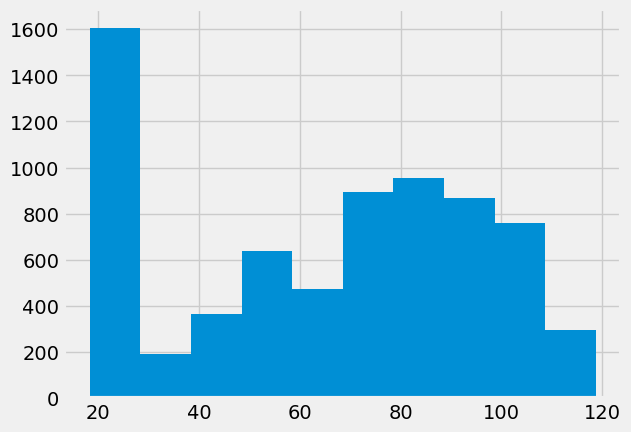

In [16]:
data.MonthlyCharges.hist()

In [17]:
# Previously assumed this was 200 for all customers.
# Mean MonthlyCharge is 68
X_test["value_of_promoting_to_churning_customer"] = data.MonthlyCharges * 3

# Previously assumed this was -80 for all customers.
X_test["cost_of_promoting_to_non_churning_customer"] = -80

In [18]:
def group_specific_profit_curve(X_test, y_test, y_pred, low_thresh, high_thresh):
    in_group = (X_test.MonthlyCharges > low_thresh) & (
        X_test.MonthlyCharges <= high_thresh
    )
    y_test_in_group = y_test[in_group]
    y_pred_in_group = y_pred[in_group]
    mean_monthly_charge = X_test.MonthlyCharges[in_group].mean()
    payoff_matrix = np.array([[0, -80], [0, 3 * mean_monthly_charge]])
    thresholds, profits = profit_curve(y_test_in_group, y_pred_in_group, payoff_matrix)
    best_thresh, best_profits = find_best_threshold_and_profit(thresholds, profits)
    return best_thresh, best_profits

Divide customers into three groups and assign different thresholds for each

In [19]:
# Find ideal threshold for customers paying less than $20/month
thresh_low, profits_low = group_specific_profit_curve(X_test, y_test, y_pred, 0, 20)
# Find ideal threshold for customers paying between $20 and $60/month
thresh_medium, profits_medium = group_specific_profit_curve(
    X_test, y_test, y_pred, 20, 60
)
# Find ideal threshold for customers paying between $60 and $100/month
thresh_high, profits_high = group_specific_profit_curve(X_test, y_test, y_pred, 60, 100)
# Find ideal threshold for customers paying more than $100/month
thresh_very_high, profits_very_high = group_specific_profit_curve(
    X_test, y_test, y_pred, 100, 200
)

print(
    f"""
With flexible thresholds, the profit is {(profits_low + profits_medium + profits_high + profits_very_high):.0f}.
Previous profit was {best_profits}"""
)


With flexible thresholds, the profit is 44919.
Previous profit was 32360
